<a href="https://colab.research.google.com/github/ErikFantomex/Redes-Neuronales/blob/main/BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input


import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomContrast


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd "/content/drive/MyDrive/Breast Cancer"
%ls

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1lYVcB8kV_8qippgYWMoymqQXWF8kw7Os/Breast Cancer
breastCancer.ipynb  healthy/  sick/


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (480, 640) #(256, 256)
directory = "./"

img_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='binary',
    class_names=["healthy", "sick"],
    color_mode='rgb',
    #batch_size=BATCH_SIZE,              # Ocultar?
    image_size=IMG_SIZE,      # Usar o quitar?
    shuffle=True,
    #seed=98,                  # Dejar para pruebas?
    #validation_split=0.2,
    #subset="training",
    interpolation='bilinear',
    crop_to_aspect_ratio=True  #True?
)

train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='binary',
    class_names=["healthy", "sick"],
    color_mode='rgb',
    image_size=IMG_SIZE,      # Usar o quitar?
    shuffle=True,
    seed=98,                  # Dejar para pruebas?
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    crop_to_aspect_ratio=True  #True?
)

valid_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='binary',
    class_names=["healthy", "sick"],
    color_mode='rgb',
    #batch_size=BATCH_SIZE,              # Ocultar?
    image_size=IMG_SIZE,      # Usar o quitar?
    shuffle=True,
    seed=98,                  # Dejar para pruebas?
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    crop_to_aspect_ratio=True  #True?
)

Found 4736 files belonging to 2 classes.
Found 4736 files belonging to 2 classes.
Using 3789 files for training.
Found 4736 files belonging to 2 classes.
Using 947 files for validation.


In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.models.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomContrast(factor=[0.05, 0.25]))
    
    return data_augmentation

data_augmentation = data_augmenter()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


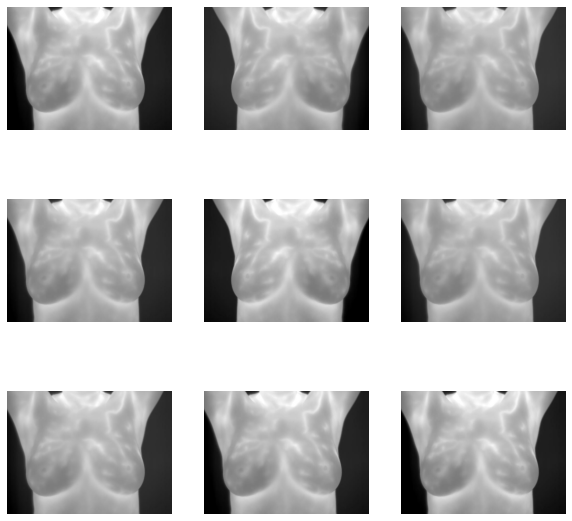

In [ ]:
# Training dataset

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


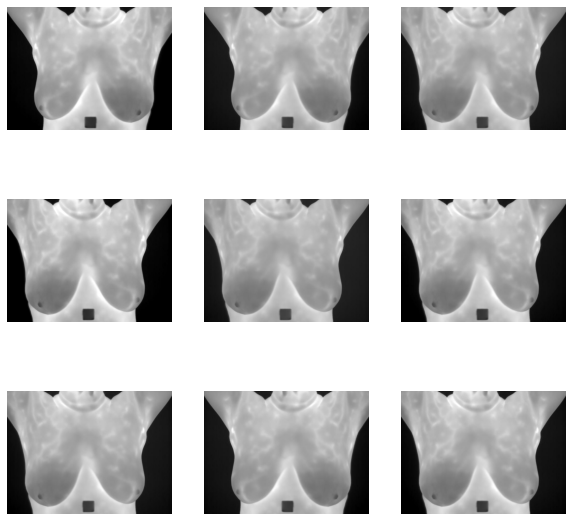

In [ ]:
#Validation Dataset
for image, _ in valid_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

#Modelo mobilenet_v2 


In [ ]:
#preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input



In [ ]:
def breast_cancer_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units=1, activation='linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = breast_cancer_model(IMG_SIZE, data_augmentation)

171327488/171317808 [==============================] - 1s 0us/step


#Hiperparámetros

In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#Entrenamiento

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=valid_dataset, epochs=initial_epochs)

Epoch 1/5
 79/119 [==================>...........] - ETA: 34:31 - loss: 0.4683 - accuracy: 0.7971

#Resultados

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning del modelo

In [ ]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300 #120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

#Entrenamiento

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

#Resultados

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()